In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    one_hot_from_int
)
import PIL.Image
import numpy as np
import os
import argparse
from tqdm import tqdm
import json
import pickle
import matplotlib.pyplot as plt
import utils_bigbigan as ubigbi

model = BigGAN.from_pretrained('biggan-deep-256').cuda()

/afs/csail.mit.edu/u/j/jahanian/.conda/envs/stenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/csail.mit.edu/u/j/jahanian/.conda/envs/stenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/csail.mit.edu/u/j/jahanian/.conda/envs/stenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def convert_to_images(obj):
    """ Convert an output tensor from BigGAN in a list of images.
    """
    # need to fix import, see: https://github.com/huggingface/pytorch-pretrained-BigGAN/pull/14/commits/68a7446951f0b9400ebc7baf466ccc48cdf1b14c
    if not isinstance(obj, np.ndarray):
        obj = obj.detach().numpy()
    obj = obj.transpose((0, 2, 3, 1))
    obj = np.clip(((obj + 1) / 2.0) * 256, 0, 255)
    img = []
    for i, out in enumerate(obj):
        out_array = np.asarray(np.uint8(out), dtype=np.uint8)
        img.append(PIL.Image.fromarray(out_array))
    return img

In [41]:
dataset_name = '/data/vision/phillipi/ganclr/datasets/nn_biggan256tr1-png_steer_rnd_std1.0_100_1_samples'
class_name = 'n13040303'
with open(os.path.join(dataset_name, 'train', class_name, 'z_dataset.pkl') ,'rb') as fid:
    z_d = pickle.load(fid)

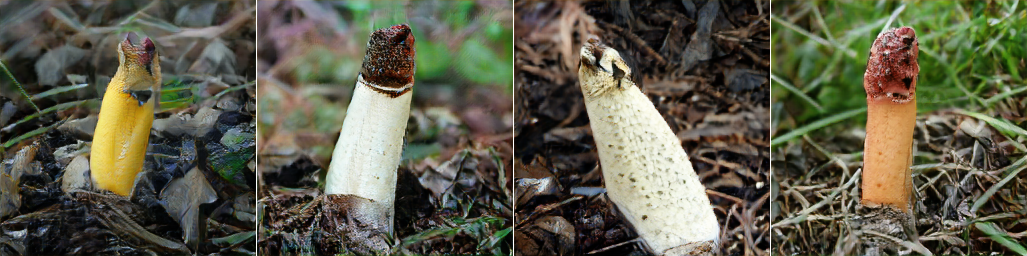

In [44]:
A_z_list = []
A_str_list =[]
bs = 4
idx_rnd = np.random.randint(1300, size=bs)
idx_list = []
for i in range(bs):
    name = list(z_d.keys())[idx_rnd[i]]
    A_str_list.append(name)
    A_z_list.append(z_d[name][0])
    idx_list.append(z_d[list(z_d.keys())[idx_rnd[i]]][1])


class_vector = one_hot_from_int(idx_list, batch_size=bs)
class_vector = torch.from_numpy(class_vector).cuda()
noise_vector = torch.from_numpy(np.stack(A_z_list)).cuda()

# from model
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation=1.0)
output = output.cpu()
ims = convert_to_images(output)
ubigbi.imshow(ubigbi.imgrid(np.stack(ims), cols=4))

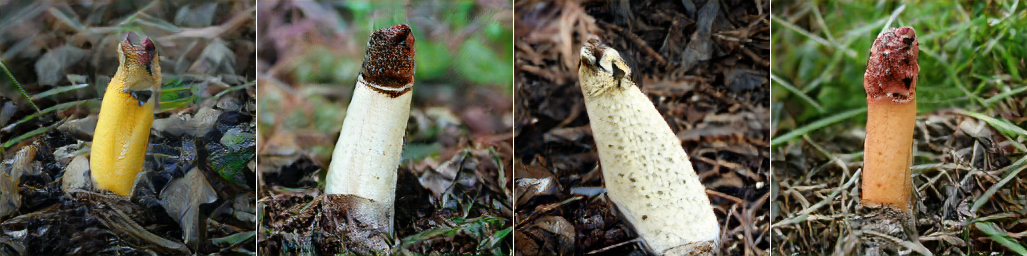

In [45]:
# now from disk
ims_disk = []
for i in range(bs):
    im = PIL.Image.open(os.path.join(dataset_name, 'train', class_name, A_str_list[i]))
    ims_disk.append(im)
ubigbi.imshow(ubigbi.imgrid(np.stack(ims_disk), cols=4))

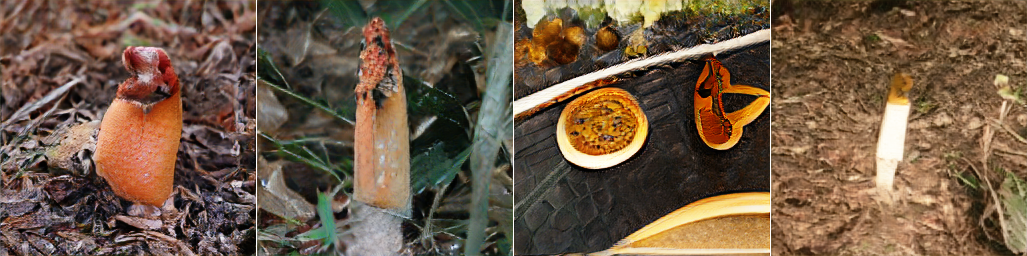

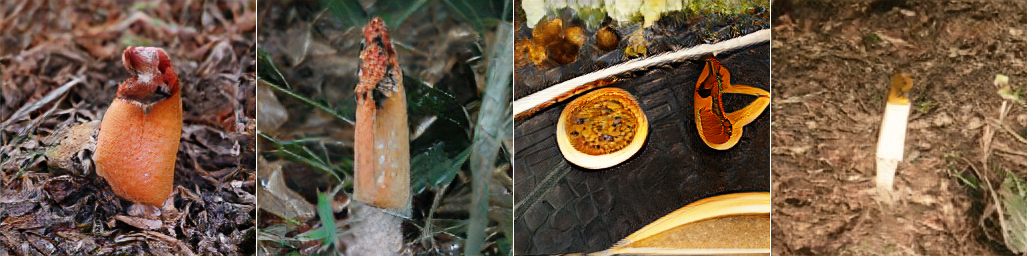

In [47]:
B_str_list = []
B_str_list.append('seed0994_sample01299_anchor.png')
B_str_list.append('seed0994_sample01214_1.0_1.png')
B_str_list.append('seed0994_sample00962_1.0_1.png')
B_str_list.append('seed0994_sample01075_anchor.png')
B_z_list = []
idx_list = []
for i in range(len(B_str_list)):
    B_z_list.append(z_d[B_str_list[i]][0])
    idx_list.append(z_d[B_str_list[i]][1])

class_vector = one_hot_from_int(idx_list, batch_size=bs)
class_vector = torch.from_numpy(class_vector).cuda()
noise_vector = torch.from_numpy(np.stack(B_z_list)).cuda()

# from model
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation=1.0)
output = output.cpu()
ims = convert_to_images(output)
ubigbi.imshow(ubigbi.imgrid(np.stack(ims), cols=4))

# now from disk
ims_disk = []
for i in range(bs):
    im = PIL.Image.open(os.path.join(dataset_name, 'train', class_name, B_str_list[i]))
    ims_disk.append(im)
ubigbi.imshow(ubigbi.imgrid(np.stack(ims_disk), cols=4))